In [12]:
import pandas as pd
import numpy as np
import ppinetsim
import networkx as nx
from os.path import join
import matplotlib.pyplot as plt
import json
import itertools as itt
import seaborn as sns
from scipy.stats import wasserstein_distance
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def to_string(x):
    return ''.join(str(x).split('.'))

def load_results(test_method, acceptance_threshold, false_positive_rate, false_negative_rate):
    infix = f'accTh{to_string(acceptance_threshold)}_FPR{to_string(false_positive_rate)}_FNR{to_string(false_negative_rate)}'
    directory = f'output_results/{test_method}/{infix}'
    posteriors = pd.read_csv(f'{directory}/likelihood_{test_method}_{infix}.csv')
    with open(f'{directory}/all_results_{test_method}_{infix}.json') as fp:
        all_results = json.load(fp)
    return posteriors, all_results

In [3]:
def deltas_sods(test_method, acceptance_threshold, fprs=None, fnrs=None, pivot=True):
    if fprs is None:
        fprs = [0.0,0.003125,0.00625,0.0125,0.025,0.05,0.1,0.2,0.4]
    if fnrs is None:
        fnrs = [0.0,0.1,0.2,0.3,0.4]
    data = {'FPR': [], 'FNR': [], 'delta_sod': []}
    for fpr, fnr in itt.product(fprs, fnrs):
        _, all_results = load_results(test_method, acceptance_threshold, fpr, fnr)
        sod_ba = 0.0
        sod_er = 0.0
        for dist, generator, _ in all_results:
            if generator == 'barabasi-albert':
                sod_ba += dist
            else:
                sod_er += dist
        data['delta_sod'].append((sod_ba - sod_er) / sod_er)
        data['FPR'].append(fpr)
        data['FNR'].append(fnr)
    deltas = pd.DataFrame(data=data)
    if pivot:
        return deltas.pivot('FPR', 'FNR', 'delta_sod')
    return deltas

In [4]:
def get_parameters(test_method, generator):
    if test_method == 'AP-MS':
        parameters = ppinetsim.Parameters('parameter_settings/all_param_combinations/AP-MS/params_AP-MS_accTh00_FPR00_FNR00.json')
    else:
        parameters = ppinetsim.Parameters('parameter_settings/all_param_combinations/Y2H/params_Y2H_accTh00_FPR00_FNR00.json')
    parameters.generator = generator
    return parameters

In [6]:
params_apms_er = get_parameters('AP-MS', 'erdos-renyi')
params_apms_ba = get_parameters('AP-MS', 'barabasi-albert')
params_y2h_er = get_parameters('Y2H', 'erdos-renyi')
params_y2h_ba = get_parameters('Y2H', 'barabasi-albert')

In [30]:
degree_dist_observed_apms = np.loadtxt('ppinetsim/data/AP-MS/degree_dist_observed.out')
degree_dist_observed_y2h = np.loadtxt('ppinetsim/data/Y2H/degree_dist_observed.out')

In [18]:
degree_dist_ground_truth_apms = {'erdos-renyi': [], 'barabasi-albert': []}
for _ in range(50):
    adj_ground_truth_er, _, _, _ = ppinetsim.initialize_matrices(params_apms_er)
    degree_dist_ground_truth_apms['erdos-renyi'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_er)))
    adj_ground_truth_ba, _, _, _ = ppinetsim.initialize_matrices(params_apms_ba)
    degree_dist_ground_truth_apms['barabasi-albert'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_ba)))
dists_apms_er = [wasserstein_distance(degree_dist_observed_apms[0, ], degree_dist_ground_truth[0, ],
                                      degree_dist_observed_apms[1, ], degree_dist_ground_truth[1, ])
                 for degree_dist_ground_truth in degree_dist_ground_truth_apms['erdos-renyi']]
dists_apms_ba = [wasserstein_distance(degree_dist_observed_apms[0, ], degree_dist_ground_truth[0, ],
                                      degree_dist_observed_apms[1, ], degree_dist_ground_truth[1, ])
                 for degree_dist_ground_truth in degree_dist_ground_truth_apms['barabasi-albert']]
distances_apms = pd.DataFrame(data={'Ground truth': ['Ground truth\nPL-distributed' for _ in range(50)] +
                                                    ['Ground truth\nbinomially distributed' for _ in range(50)],
                                    'EMD': dists_apms_ba + dists_apms_er})

In [20]:
degree_dist_ground_truth_y2h = {'erdos-renyi': [], 'barabasi-albert': []}
for _ in range(50):
    adj_ground_truth_er, _, _, _ = ppinetsim.initialize_matrices(params_y2h_er)
    degree_dist_ground_truth_y2h['erdos-renyi'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_er)))
    adj_ground_truth_ba, _, _, _ = ppinetsim.initialize_matrices(params_y2h_ba)
    degree_dist_ground_truth_y2h['barabasi-albert'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_ba)))
dists_y2h_er = [wasserstein_distance(degree_dist_observed_y2h[0, ], degree_dist_ground_truth[0, ],
                                     degree_dist_observed_y2h[1, ], degree_dist_ground_truth[1, ])
                for degree_dist_ground_truth in degree_dist_ground_truth_y2h['erdos-renyi']]
dists_y2h_ba = [wasserstein_distance(degree_dist_observed_y2h[0, ], degree_dist_ground_truth[0, ],
                                     degree_dist_observed_y2h[1, ], degree_dist_ground_truth[1, ])
                for degree_dist_ground_truth in degree_dist_ground_truth_y2h['barabasi-albert']]
distances_y2h = pd.DataFrame(data={'Ground truth': ['Ground truth\nPL-distributed' for _ in range(50)] +
                                                   ['Ground truth\nbinomially distributed' for _ in range(50)],
                                   'EMD': dists_y2h_ba + dists_y2h_er})

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


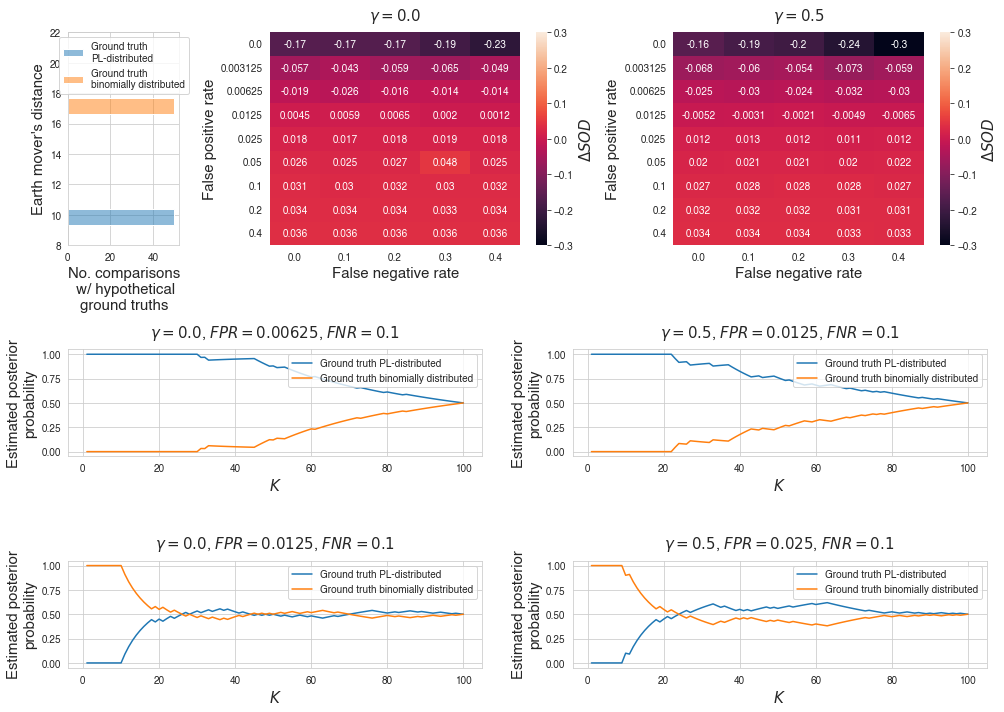

In [31]:
fig, axes = plt.subplot_mosaic(mosaic=[
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['E','E','E','E','E','F','F','F','F','F'],
    ['E','E','E','E','E','F','F','F','F','F']],figsize=(14,10))
sns.histplot(data=distances_apms, y='EMD', hue='Ground truth', ax=axes['G'])
axes['G'].set_ylabel("Earth mover's distance", fontsize=15)
axes['G'].set_xlabel("No. comparisons\n w/ hypothetical\nground truths", fontsize=15)
axes['G'].set_ylim(8,22)
sns.move_legend(axes['G'], "upper center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=True)
sns.heatmap(deltas_sods('AP-MS', 0.0),annot=True,ax=axes['A'],vmin=-.3,vmax=.3)
sns.heatmap(deltas_sods('AP-MS', 0.5),annot=True,ax=axes['B'],vmin=-.3,vmax=.3)
for label, gamma in [('A',0.0), ('B', 0.5)]:
    axes[label].set_title(r'$\gamma={}$'.format(gamma),pad=12,fontsize=15)
    axes[label].set_xlabel('False negative rate', fontsize=15)
    axes[label].set_ylabel('False positive rate', fontsize=15)
    colorbar = axes[label].collections[0].colorbar
    colorbar.set_label(r'$\Delta\mathit{SOD}$',fontsize=15)
for label, gamma, fpr in [('C', 0.0, 0.00625), ('D', 0.5, 0.0125), ('E', 0.0, 0.0125), ('F', 0.5, 0.025)]:
    posteriors, _ = load_results('AP-MS', acceptance_threshold=gamma,
                                 false_positive_rate=fpr, false_negative_rate=0.1)
    ppinetsim.plot_posteriors(posteriors, ax=axes[label], parameters={'acceptance_threshold': gamma,
                                                      'false_positive_rate': fpr,
                                                      'false_negative_rate': 0.1, 'test_method': 'AP-MS'})
    axes[label].set_title(r'$\gamma={}$, $FPR={}$, $FNR=0.1$'.format(gamma, fpr),pad=12,fontsize=15)
    axes[label].set_ylabel('Estimated posterior\nprobability',fontsize=15)
    axes[label].set_xlabel(r'$K$', fontsize=15)
    handles, labels = axes[label].get_legend_handles_labels()
    axes[label].legend(handles=handles[0:], labels=labels[0:],loc='upper right')
fig.tight_layout()
fig.savefig('simulation_AP-MS.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


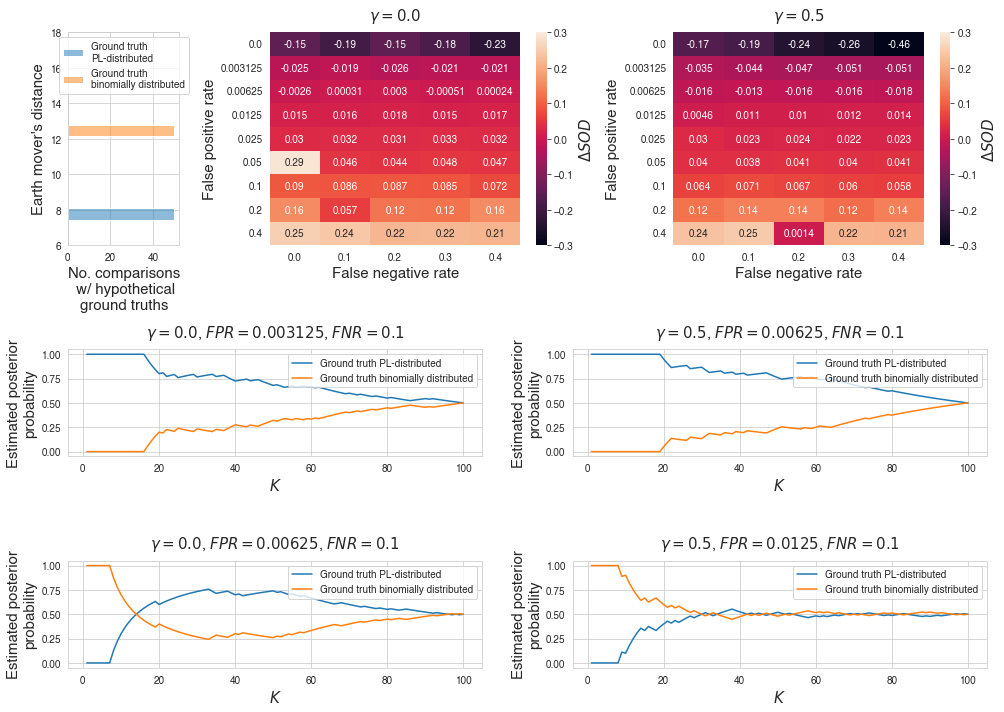

In [32]:
fig, axes = plt.subplot_mosaic(mosaic=[
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['E','E','E','E','E','F','F','F','F','F'],
    ['E','E','E','E','E','F','F','F','F','F']],figsize=(14,10))
sns.histplot(data=distances_y2h, y='EMD', hue='Ground truth', ax=axes['G'])
axes['G'].set_ylabel("Earth mover's distance", fontsize=15)
axes['G'].set_xlabel("No. comparisons\n w/ hypothetical\nground truths", fontsize=15)
axes['G'].set_ylim(6,18)
sns.move_legend(axes['G'], "upper center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=True)
sns.heatmap(deltas_sods('Y2H', 0.0),annot=True,ax=axes['A'],vmin=-.3,vmax=.3)
sns.heatmap(deltas_sods('Y2H', 0.5),annot=True,ax=axes['B'],vmin=-.3,vmax=.3)
for label, gamma in [('A',0.0), ('B', 0.5)]:
    axes[label].set_title(r'$\gamma={}$'.format(gamma),pad=12,fontsize=15)
    axes[label].set_xlabel('False negative rate', fontsize=15)
    axes[label].set_ylabel('False positive rate', fontsize=15)
    colorbar = axes[label].collections[0].colorbar
    colorbar.set_label(r'$\Delta\mathit{SOD}$',fontsize=15)
for label, gamma, fpr in [('C', 0.0, 0.003125), ('D', 0.5, 0.00625), ('E', 0.0, 0.00625), ('F', 0.5, 0.0125)]:
    posteriors, _ = load_results('Y2H', acceptance_threshold=gamma,
                                 false_positive_rate=fpr, false_negative_rate=0.1)
    ppinetsim.plot_posteriors(posteriors, ax=axes[label], parameters={'acceptance_threshold': gamma,
                                                      'false_positive_rate': fpr,
                                                      'false_negative_rate': 0.1, 'test_method': 'Y2H'})
    axes[label].set_title(r'$\gamma={}$, $FPR={}$, $FNR=0.1$'.format(gamma, fpr),pad=12,fontsize=15)
    axes[label].set_ylabel('Estimated posterior\nprobability',fontsize=15)
    axes[label].set_xlabel(r'$K$', fontsize=15)
    handles, labels = axes[label].get_legend_handles_labels()
    axes[label].legend(handles=handles[0:], labels=labels[0:],loc='upper right')
fig.tight_layout()
fig.savefig('simulation_Y2H.pdf')